# Mise en place

In [1]:
from google.colab import drive

In [2]:
import pandas as pd
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px
import re
import spacy
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
# Importer les données prétraitées pour le machine learning
data = pd.read_csv('/content/drive/MyDrive/Parcours_OCR_AI_Engineer/Projets/P004_/En_Cours/application_train_PourML.csv', nrows=7500)
bureau = pd.read_csv('/content/drive/MyDrive/Parcours_OCR_AI_Engineer/Projets/P004_/En_Cours/bureau_PourML.csv', nrows=7500)
data_test = pd.read_csv('/content/drive/MyDrive/Parcours_OCR_AI_Engineer/Projets/P004_/En_Cours/application_test_PourML.csv', nrows=7500)


In [3]:
#Afficher toute les colonnes
pd.set_option('display.max_columns', None)

# Machine Learning

## Préparation

In [4]:
# Make a new dataframe for polynomial features
poly_features = data[['Taux_Endettement', 'RatioVieTravail', 'Age','RatioCreditRevenu','TempsPret', 'TARGET']]
poly_features_test = data_test[['Taux_Endettement', 'RatioVieTravail', 'Age','RatioCreditRevenu','TempsPret']]

# imputer for handling missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = 'median')

poly_target = poly_features['TARGET']

poly_features = poly_features.drop(columns = ['TARGET'])

# Need to impute missing values
poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)

from sklearn.preprocessing import PolynomialFeatures

# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)

In [5]:
# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape)

Polynomial Features shape:  (7500, 56)


In [6]:
poly_transformer.get_feature_names_out(input_features = ['Taux_Endettement', 'RatioVieTravail', 'Age','RatioCreditRevenu','TempsPret'])[:15]

array(['1', 'Taux_Endettement', 'RatioVieTravail', 'Age',
       'RatioCreditRevenu', 'TempsPret', 'Taux_Endettement^2',
       'Taux_Endettement RatioVieTravail', 'Taux_Endettement Age',
       'Taux_Endettement RatioCreditRevenu', 'Taux_Endettement TempsPret',
       'RatioVieTravail^2', 'RatioVieTravail Age',
       'RatioVieTravail RatioCreditRevenu', 'RatioVieTravail TempsPret'],
      dtype=object)

In [7]:
# Create a dataframe of the features
columns = poly_transformer.get_feature_names_out(['Taux_Endettement', 'RatioVieTravail', 'Age','RatioCreditRevenu','TempsPret'])
poly_features = pd.DataFrame(poly_features, columns = columns)

# Add in the target
poly_features['TARGET'] = poly_target

# Find the correlations with the target
poly_corrs = poly_features.corr()['TARGET'].sort_values()

# Display most negative and most positive
print(poly_corrs.head(10))
print(poly_corrs.tail(5))

RatioVieTravail Age                     -0.078682
RatioVieTravail Age^2                   -0.076867
RatioVieTravail                         -0.074119
RatioVieTravail Age TempsPret           -0.065133
RatioVieTravail^2                       -0.060155
RatioVieTravail Age RatioCreditRevenu   -0.058774
RatioVieTravail^2 Age                   -0.058574
Taux_Endettement RatioVieTravail Age    -0.057983
RatioVieTravail TempsPret               -0.057419
RatioVieTravail^2 TempsPret             -0.055862
Name: TARGET, dtype: float64
TempsPret                        0.010077
RatioCreditRevenu TempsPret^2    0.010629
Taux_Endettement TempsPret       0.011513
TARGET                           1.000000
1                                     NaN
Name: TARGET, dtype: float64


In [8]:
# Put test features into dataframe
poly_features_test = pd.DataFrame(poly_features_test,
                                  columns = poly_transformer.get_feature_names_out(['Taux_Endettement', 'RatioVieTravail', 'Age','RatioCreditRevenu','TempsPret']))

# Merge polynomial features into training dataframe
poly_features['SK_ID_CURR'] = data['SK_ID_CURR']
app_train_poly = data.merge(poly_features, on = 'SK_ID_CURR', how = 'left')

# Merge polnomial features into testing dataframe
poly_features_test['SK_ID_CURR'] = data_test['SK_ID_CURR']
app_test_poly = data_test.merge(poly_features_test, on = 'SK_ID_CURR', how = 'left')

# Align the dataframes
app_train_poly, app_test_poly = app_train_poly.align(app_test_poly, join = 'inner', axis = 1)

# Print out the new shapes
print('Training data with polynomial features shape: ', app_train_poly.shape)
print('Testing data with polynomial features shape:  ', app_test_poly.shape)

Training data with polynomial features shape:  (7500, 294)
Testing data with polynomial features shape:   (7500, 294)


In [9]:
app_train_domain = data.copy()
app_test_domain = data_test.copy()

#app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL'] # Ok RatioCreditRevenu
#app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL'] # Ok Taux_Endettement
#app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']  #Ok TempsPret
#app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH'] #Ok RatioVieTravail

#app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL'] #ok RatioCreditRevenu
#app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL'] #Ok Taux_Endettement
#app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']  #Ok TempsPret
#app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH'] #ok RatioVieTravail

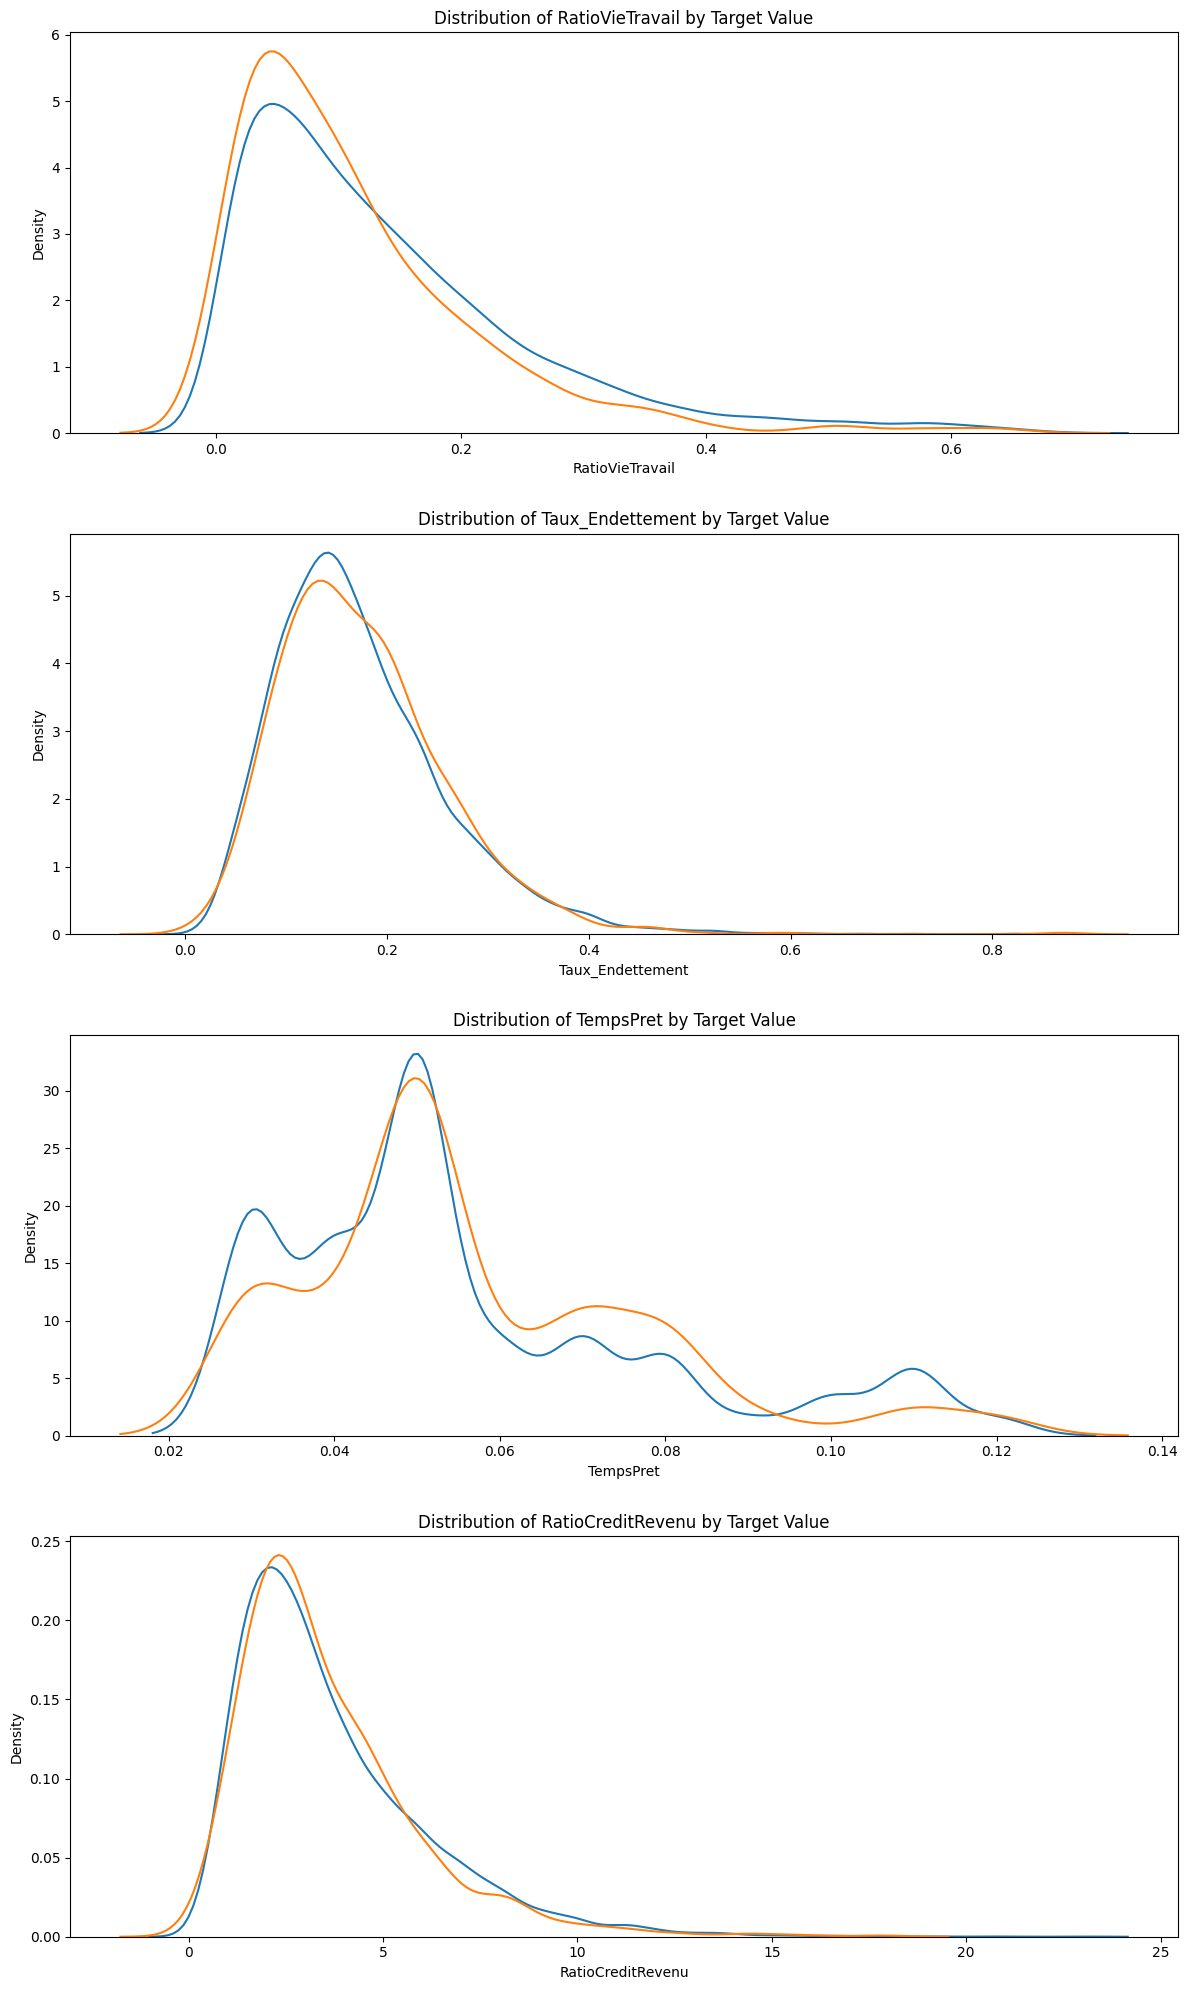

In [10]:
plt.figure(figsize = (12, 20))
# iterate through the new features
for i, feature in enumerate(['RatioVieTravail', 'Taux_Endettement', 'TempsPret', 'RatioCreditRevenu']):

    # create a new subplot for each source
    plt.subplot(4, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 1, feature], label = 'target == 1')

    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');

plt.tight_layout(h_pad = 2.5)

## Submission

In [11]:
# one-hot encoding of categorical variables
data = pd.get_dummies(data)
data_test = pd.get_dummies(data_test)

print('Training Features shape: ', data.shape)
print('Testing Features shape: ', data_test.shape)

Training Features shape:  (7500, 246)
Testing Features shape:  (7500, 249)


In [12]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
import pandas as pd

# Supprimer la cible des données d'entraînement
if 'TARGET' in data:
    train = data.drop(columns=['TARGET'])
else:
    train = data.copy()

# Noms des caractéristiques
features = list(train.columns)

# Copie des données de test
test = data_test.copy()

# Assurez-vous que test a les mêmes colonnes que train
# Cela ajoutera les colonnes manquantes à 'test' avec des valeurs NaN
test = test.reindex(columns=features)

# Imputer pour gérer les valeurs manquantes
imputer = SimpleImputer(strategy='median')

# Scaler pour normaliser les caractéristiques
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit sur les données d'entraînement
imputer.fit(train)

# Transformer à la fois les données d'entraînement et de test
train = imputer.transform(train)
test = imputer.transform(test)

# Répétez avec le scaler
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)


Training data shape:  (7500, 245)
Testing data shape:  (7500, 245)


In [13]:
train_labels = data['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
data, data_test = data.align(data_test, join = 'inner', axis = 1)

# Add the target back in
data['TARGET'] = train_labels

print('Training Features shape: ', data.shape)
print('Testing Features shape: ', data_test.shape)

Training Features shape:  (7500, 239)
Testing Features shape:  (7500, 238)


In [14]:
from sklearn.linear_model import LogisticRegression

# Make the model with the specified regularization parameter
log_reg = LogisticRegression(C = 0.0001)

# Train on the training data
log_reg.fit(train, train_labels)

LogisticRegression(C=0.0001)

In [15]:
log_reg_pred = log_reg.predict_proba(test)[:, 1]


In [16]:
submit = data_test[['SK_ID_CURR']]
submit['TARGET'] = log_reg_pred

submit.head()

,SK_ID_CURR,TARGET
0,100005,0.120523
1,142542,0.120687
2,158847,0.120987
3,158952,0.120103
4,161841,0.119169


In [17]:
submit.to_csv('log_reg_baseline.csv', index = False)

## Random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier
# Make the random forest classifier
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

In [19]:
# Train on the training data
random_forest.fit(train, train_labels)

# Extract feature importances
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

# Make predictions on the test data
predictions = random_forest.predict_proba(test)[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.6s finished


In [20]:
# Make a submission dataframe
submit = data_test[['SK_ID_CURR']]
submit['TARGET'] = predictions

# Save the submission dataframe
submit.to_csv('random_forest_baseline.csv', index = False)

### Bagging en appuie sur le Random Forest

Accuracy: 0.9175704989154013

In [21]:
from sklearn.impute import SimpleImputer
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, accuracy_score

# Présumons que 'data' est votre DataFrame et 'TARGET' la colonne cible
X = data.drop('TARGET', axis=1)
y = data['TARGET']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Séparer les colonnes numériques et catégorielles
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Créer des transformateurs séparés pour les colonnes numériques et catégorielles
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

# Créer un préprocesseur pour appliquer les transformations aux colonnes appropriées
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Initialiser le classificateur Random Forest avec des paramètres spécifiques
rf = RandomForestClassifier(n_estimators=100, random_state=50, verbose=1, n_jobs=-1)

# Créer le modèle de Bagging avec le Random Forest comme estimateur de base
bagging_clf = BaggingClassifier(base_estimator=rf, n_estimators=10, random_state=42)

# Créer un pipeline pour appliquer le préprocesseur et le modèle de Bagging
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('bagging_clf', bagging_clf)])

# Entraîner le modèle de Bagging
pipeline.fit(X_train, y_train)

# Faire des prédictions
predictions = pipeline.predict(X_test)

# Évaluer le modèle
print(classification_report(y_test, predictions))
print(f'Accuracy: {accuracy_score(y_test, predictions)}')


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.5s
[

              precision    recall  f1-score   support

           0       0.89      1.00      0.94      1339
           1       0.00      0.00      0.00       161

    accuracy                           0.89      1500
   macro avg       0.45      0.50      0.47      1500
weighted avg       0.80      0.89      0.84      1500

Accuracy: 0.8926666666666667


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_job

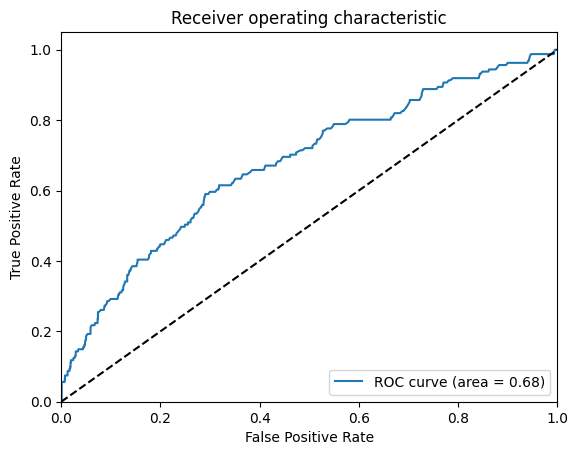

In [22]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Récupérer les probabilités des prédictions positives
probabilities = pipeline.predict_proba(X_test)[:, 1]

# Calculer les valeurs de faux positifs, vrais positifs et les seuils
fpr, tpr, thresholds = roc_curve(y_test, probabilities)

# Calculer l'aire sous la courbe (AUC)
roc_auc = auc(fpr, tpr)

# Tracer la courbe ROC
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


### Test

In [23]:
from sklearn.impute import SimpleImputer

poly_features_names = list(app_train_poly.columns)

# Créer une instance de SimpleImputer avec la stratégie 'median'
imputer = SimpleImputer(strategy='median')

poly_features = imputer.fit_transform(app_train_poly)
poly_features_test = imputer.transform(app_test_poly)

# Scale the polynomial features
scaler = MinMaxScaler(feature_range = (0, 1))

poly_features = scaler.fit_transform(poly_features)
poly_features_test = scaler.transform(poly_features_test)

random_forest_poly = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

In [24]:
# Train on the training data
random_forest_poly.fit(poly_features, train_labels)

# Make predictions on the test data
predictions = random_forest_poly.predict_proba(poly_features_test)[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


In [25]:
# Make a submission dataframe
submit = data_test[['SK_ID_CURR']]
submit['TARGET'] = predictions

# Save the submission dataframe
submit.to_csv('random_forest_baseline_engineered.csv', index = False)

In [26]:
submit['TARGET'].mean()

0.191244

In [27]:
#app_train_domain = app_train_domain.drop(columns = 'TARGET')

#domain_features_names = list(app_train_domain.columns)

# Imputer pour gérer les valeurs manquantes
#imputer = SimpleImputer(strategy='median')

#domain_features = imputer.fit_transform(app_train_domain)
#domain_features_test = imputer.transform(app_test_domain)

# Scale the domainnomial features
#scaler = MinMaxScaler(feature_range = (0, 1))

#domain_features = scaler.fit_transform(domain_features)
#domain_features_test = scaler.transform(domain_features_test)

#random_forest_domain = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

# Train on the training data
#random_forest_domain.fit(domain_features, train_labels)

# Extract feature importances
#feature_importance_values_domain = random_forest_domain.feature_importances_
#feature_importances_domain = pd.DataFrame({'feature': domain_features_names, 'importance': feature_importance_values_domain})

# Make predictions on the test data
#predictions = random_forest_domain.predict_proba(domain_features_test)[:, 1]

In [28]:
# Make a submission dataframe
submit = data_test[['SK_ID_CURR']]
submit['TARGET'] = predictions

# Save the submission dataframe
submit.to_csv('random_forest_baseline_domain.csv', index = False)

### Analyse des features importante

In [29]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better.

    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance

    Returns:
        shows a plot of the 15 most importance features

        df (dataframe): feature importances sorted by importance (highest to lowest)
        with a column for normalized importance
        """

    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()

    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()

    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))),
            df['importance_normalized'].head(15),
            align = 'center', edgecolor = 'k')

    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))

    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()

    return df



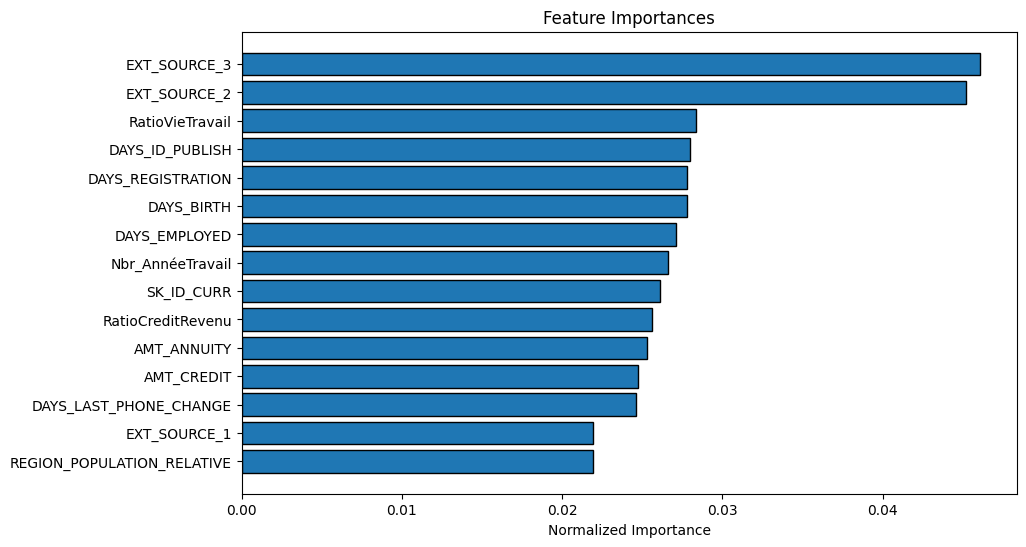

In [30]:
feature_importances_sorted = plot_feature_importances(feature_importances)


In [31]:
#feature_importances_domain_sorted = plot_feature_importances(feature_importances_domain)

# Booster Gradiant (Meilleurs résultat)

In [32]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from lightgbm import callback
import lightgbm as lgb
import gc
import matplotlib.pyplot as plt


def model(features, test_features, encoding = 'ohe', n_folds = 5):

    """Entraîner et tester un modèle de renforcement de gradient léger en utilisant
    la validation croisée.

    Paramètres
    --------
        features (pd.DataFrame):
            dataframe des caractéristiques d'entraînement à utiliser
            pour l'entraînement d'un modèle. Doit inclure la colonne TARGET.
        test_features (pd.DataFrame):
            dataframe des caractéristiques de test à utiliser
            pour faire des prédictions avec le modèle.
        encoding (str, par défaut = 'ohe'):
            méthode pour encoder les variables catégorielles. Soit 'ohe' pour l'encodage one-hot ou 'le' pour l'encodage par étiquettes entières.
            n_folds (int, par défaut = 5) : nombre de subdivisions à utiliser pour la validation croisée.

    Retour
    --------
        submission (pd.DataFrame):
                dataframe avec `SK_ID_CURR` et les probabilités de `TARGET`
                prédites par le modèle.
        feature_importances (pd.DataFrame):
            dataframe avec les importances des caractéristiques du modèle.
        valid_metrics (pd.DataFrame):
            dataframe avec les métriques de formation et de validation (ROC AUC) pour chaque subdivision et dans l'ensemble.


    """

    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']

    # Extract the labels for training
    labels = features['TARGET']

    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])


    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)

        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)

        # No categorical indices to record
        cat_indices = 'auto'

    # Integer label encoding
    elif encoding == 'le':

        # Create a label encoder
        label_encoder = LabelEncoder()

        # List for storing categorical indices
        cat_indices = []

        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)

    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")

    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)

    # Extract feature names
    feature_names = list(features.columns)

    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)

    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)

    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))

     # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])

    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])

    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []

    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):

        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]

        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, objective='binary',
                                  class_weight='balanced', learning_rate=0.05,
                                  reg_alpha=0.1, reg_lambda=0.1,
                                  subsample=0.8, n_jobs=-1, random_state=50)

        # Train the model avec le callback pour l'arrêt précoce
        model.fit(train_features, train_labels, eval_metric='auc',
                  eval_set=[(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names=['valid', 'train'], categorical_feature=cat_indices,
                  callbacks=[callback.early_stopping(stopping_rounds=200, verbose=True)])

        # Record the best iteration
        best_iteration = model.best_iteration_

        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits

        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits

        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]

        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']

        valid_scores.append(valid_score)
        train_scores.append(train_score)

    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})

    # Clean up memory
    gc.enable()
    del model, train_features, valid_features
    gc.collect()

    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})

    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)

    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))

    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))

    fold_names.append('overall')

    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores})

    return submission, feature_importances, metrics, out_of_fold


In [33]:
submission, fi, metrics, out_of_fold = model(data, data_test)
print('Baseline metrics')
print(metrics)

Training Data Shape:  (7500, 237)
Testing Data Shape:  (7500, 237)
[LightGBM] [Info] Number of positive: 718, number of negative: 5282
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004786 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10700
[LightGBM] [Info] Number of data points in the train set: 6000, number of used features: 132
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[133]	train's auc: 0.99452	train's binary_logloss: 0.269537	valid's auc: 0.718544	valid's binary_logloss: 0.44163
[LightGBM] [Info] Number of positive: 716, number of negative: 5284
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003818 secon

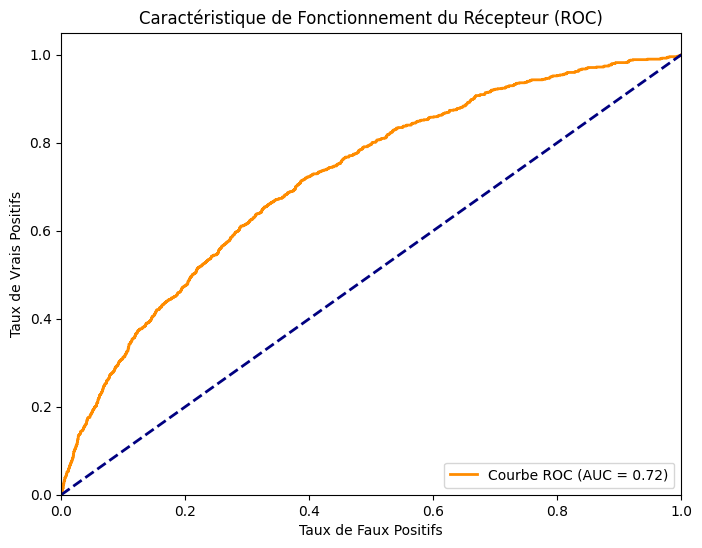

In [34]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Les vraies étiquettes de votre ensemble d'entraînement
labels = data['TARGET'].values

# Utilisez 'out_of_fold' pour les scores de probabilité prédits
# Assurez-vous que 'out_of_fold' est retourné par votre fonction 'model'
# Dans cet exemple, je suppose que 'out_of_fold' est correctement calculé et accessible

# Calcul des taux de faux positifs et vrais positifs pour la courbe ROC
fpr, tpr, thresholds = roc_curve(labels, out_of_fold)
roc_auc = auc(fpr, tpr)

# Tracé de la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Courbe ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrais Positifs')
plt.title('Caractéristique de Fonctionnement du Récepteur (ROC)')
plt.legend(loc="lower right")
plt.show()


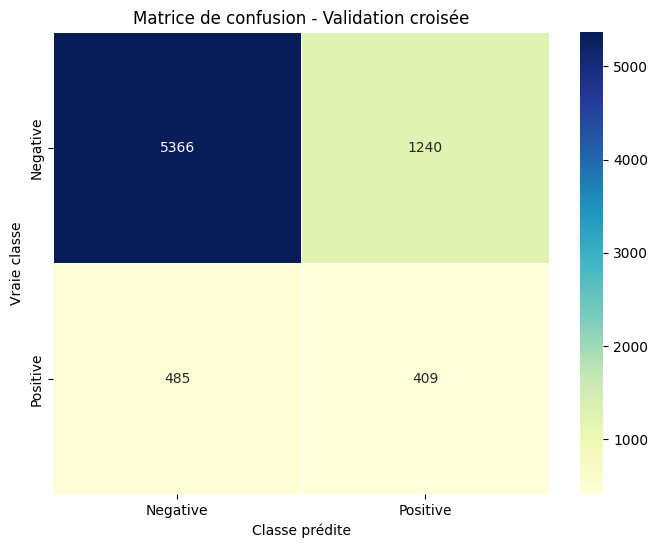

Precision: 0.2480
Recall: 0.4575
Specificity: 0.8123
F1 Score: 0.3217


In [35]:
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Utilisez `out_of_fold` comme vos prédictions et `labels` comme les vraies étiquettes

# Convertir les prédictions out-of-fold en classe prédite (1 si proba >= 0.5, sinon 0)
y_pred_oof = np.where(out_of_fold >= 0.5, 1, 0)

# Calcul de la matrice de confusion
cm = confusion_matrix(labels, y_pred_oof)

# Affichage de la matrice de confusion avec Seaborn pour une meilleure lisibilité
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, cmap="YlGnBu", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title('Matrice de confusion - Validation croisée')
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')
plt.show()

# Calcul des métriques supplémentaires à partir de la matrice de confusion
tn, fp, fn, tp = cm.ravel()
precision = precision_score(labels, y_pred_oof)
recall = recall_score(labels, y_pred_oof)
specificity = tn / (tn + fp)
f1_score = f1_score(labels, y_pred_oof)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1 Score: {f1_score:.4f}")


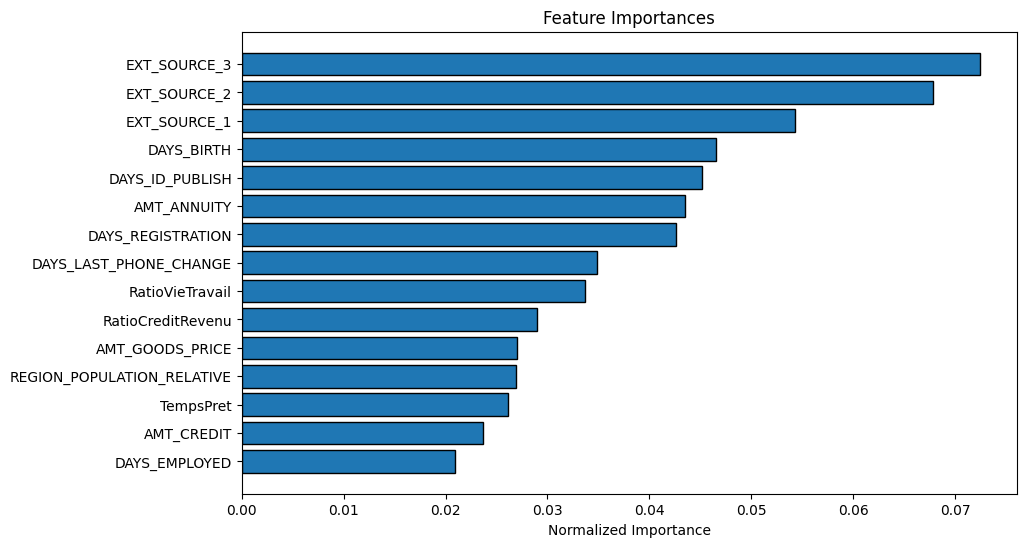

In [36]:
fi_sorted = plot_feature_importances(fi)


# Classification et HyperParamètre

### DummyCLassifier Test

In [37]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report

# Étiquettes réelles
y = data['TARGET'].values

# Diviser le jeu de données en entraînement et en test
X_train, X_test, y_train, y_test = train_test_split(data['ScoreMetier'].values.reshape(-1, 1), y, test_size=0.2, random_state=42)

# Création d'un modèle de référence simple qui prédit toujours la classe la plus fréquente dans l'ensemble d'entraînement
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train, y_train)

# Prédiction sur l'ensemble de test en utilisant le modèle de référence simple
y_pred_dummy = dummy_clf.predict(X_test)

# Évaluation du modèle de référence simple
print("Rapport de classification pour le modèle de référence simple :")
print(classification_report(y_test, y_pred_dummy))


Rapport de classification pour le modèle de référence simple :
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      1339
           1       0.00      0.00      0.00       161

    accuracy                           0.89      1500
   macro avg       0.45      0.50      0.47      1500
weighted avg       0.80      0.89      0.84      1500



In [38]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from imblearn.pipeline import make_pipeline

# Étiquettes réelles
#y = data['TARGET'].values

# Préparation des caractéristiques pour l'entraînement
#X = data['ScoreMetier']

# Diviser le jeu de données en entraînement et en test
#X_train, X_test, y_train, y_test = train_test_split(data['ScoreMetier'].values.reshape(-1, 1), y, test_size=0.2, random_state=42)

# Présumons que 'data' est votre DataFrame et 'TARGET' la colonne cible
X = data.drop('TARGET', axis=1)
y = data['TARGET']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Imputation des valeurs manquantes après la division
imputer = SimpleImputer(strategy='mean')  # Vous pouvez changer la stratégie
X_train = imputer.fit_transform(X_train)  # Fit et transform sur l'ensemble d'entraînement
X_test = imputer.transform(X_test)  # Transform sur l'ensemble de test

# Définition de la grille d'hyperparamètres à tester
#param_grid = {
    #'gradientboostingclassifier__n_estimators': [50, 100, 200, 300, 400],
    #'gradientboostingclassifier__learning_rate': [0.025, 0.05, 0.1, 0.2, 0.25],
    #'gradientboostingclassifier__max_depth': [2, 3, 4, 5, 6]}

#param_grid = {
    #'gradientboostingclassifier__n_estimators': [100, 200, 300],  # Réduction du nombre d'estimateurs
    #'gradientboostingclassifier__learning_rate': [0.01, 0.05, 0.1],  # Réduction du taux d'apprentissage
    #'gradientboostingclassifier__max_depth': [4, 5, 6]  # Augmentation légère de la profondeur maximale}

#param_grid = {
    #'gradientboostingclassifier__n_estimators': [50, 75, 100],  # Plus petit nombre d'estimateurs
    #'gradientboostingclassifier__learning_rate': [0.01, 0.02, 0.05],  # Taux d'apprentissage plus faible
    #'gradientboostingclassifier__max_depth': [3, 4],  # Profondeurs peu profondes pour éviter le surajustement

    #'gradientboostingclassifier__subsample': [0.8, 0.9],  # Sous-échantillonnage pour introduire plus de variance
    #'gradientboostingclassifier__min_samples_split': [2, 4, 6],  # Minimum nombre d'échantillons requis pour scinder un nœud
    #'gradientboostingclassifier__min_samples_leaf': [1, 2, 3]  # Minimum nombre d'échantillons requis à un nœud feuille}

param_grid = {
    'gradientboostingclassifier__n_estimators': [100, 120],  # Exploration autour du meilleur paramètre précédent
    'gradientboostingclassifier__learning_rate': [ 0.05, 0.07],  # Autour de la meilleure valeur trouvée, plus de finesse
    'gradientboostingclassifier__max_depth': [3, 4],  # Le 4 semble être un bon compromis, testez autour

    'gradientboostingclassifier__min_samples_split': [6, 8, 10],  # Augmentez légèrement pour voir si cela réduit le surajustement
    'gradientboostingclassifier__min_samples_leaf': [1, 2],  # Testez pour voir si augmenter légèrement réduit les FP
    'gradientboostingclassifier__subsample': [0.9, 0.95],  # Tester autour de 0.9 pour trouver le meilleur équilibre
}


# Création du modèle GBM
gbm = GradientBoostingClassifier(random_state=42)

# Création d'une pipeline qui intègre SMOTE et le modèle GBM
pipeline = make_pipeline(SMOTE(random_state=42), gbm)

# Création de l'instance GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=2, scoring='accuracy', n_jobs=-1)

# Entraînement du modèle avec GridSearchCV
grid_search.fit(X_train, y_train)

# Meilleur modèle après Grid Search
best_gbm = grid_search.best_estimator_.steps[-1][1] # Récupère le modèle GBM du pipeline

# Prédiction sur l'ensemble de test avec le meilleur modèle
y_pred = best_gbm.predict(X_test)

# Évaluation du modèle
print(classification_report(y_test, y_pred))

# Affichage des meilleurs paramètres
print("Meilleurs paramètres: ", grid_search.best_params_)


              precision    recall  f1-score   support

           0       0.89      1.00      0.94      1339
           1       0.67      0.01      0.02       161

    accuracy                           0.89      1500
   macro avg       0.78      0.51      0.48      1500
weighted avg       0.87      0.89      0.84      1500

Meilleurs paramètres:  {'gradientboostingclassifier__learning_rate': 0.07, 'gradientboostingclassifier__max_depth': 3, 'gradientboostingclassifier__min_samples_leaf': 1, 'gradientboostingclassifier__min_samples_split': 6, 'gradientboostingclassifier__n_estimators': 120, 'gradientboostingclassifier__subsample': 0.95}


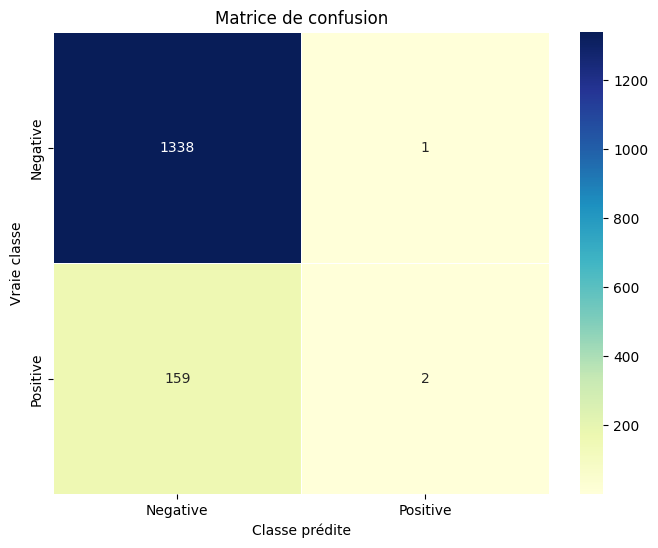

Precision: 0.6667
Recall: 0.0124
Specificity: 0.9993
F1 Score: 0.0244


In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Prédiction sur l'ensemble de test avec le meilleur modèle obtenu après GridSearchCV
y_pred = best_gbm.predict(X_test)

# Calcul de la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# Affichage de la matrice de confusion avec Seaborn pour une meilleure lisibilité
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, cmap="YlGnBu", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title('Matrice de confusion')
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')
plt.show()

# Calcul des métriques supplémentaires à partir de la matrice de confusion
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)
specificity = tn / (tn + fp)
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1 Score: {f1_score:.4f}")


AUC-ROC: 0.7541318959638925


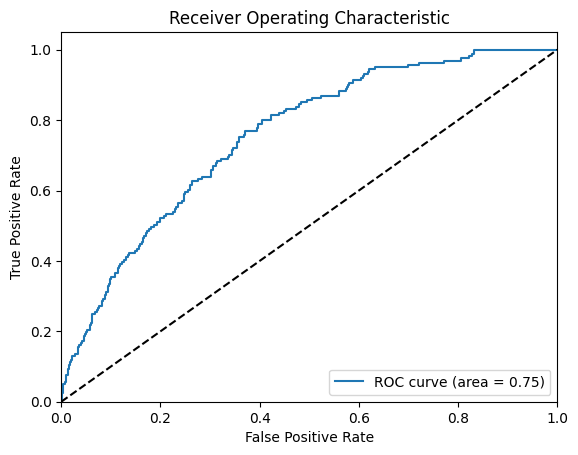

In [40]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# Assurez-vous d'avoir y_test et les probabilités prédites y_pred_proba
# Si vous n'avez pas déjà calculé les probabilités prédites, utilisez :
y_pred_proba = best_gbm.predict_proba(X_test)[:, 1]

# Calcul de l'AUC-ROC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'AUC-ROC: {roc_auc}')

# Calcul et tracé de la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Dessine une ligne diagonale pour la performance au hasard
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()
